In [7]:
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.covariance import MinCovDet
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from matplotlib.colors import TwoSlopeNorm, LogNorm
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

In [8]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(df)
    return nullOrd


def computeCorrelation(df, p=0.05):
    """ Compute pairwise correlation, p-value and pair counts """
    correlations = []
    for method in ['kendall', kendalltaur_pval, countPair]:
        values = df.corr(method=method).stack()
        correlations.append(values)
    correlations = (
        pd.concat(correlations, axis=1)
        .reset_index()
        .rename(columns={'level_0': 'feature1',
                         'level_1': 'feature2',
                         0: 'R', 1: 'p', 2: 'n'}))
    correlations['significant'] = correlations['p'] < p
    correlations = correlations[correlations['feature1'] != correlations['feature2']]
    return correlations


def kendalltaur_pval(x,y):
    try:
        return kendalltau(x,y)[1]
    except ValueError:
        return np.nan


def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)


def plotTargetCorrelation(correlations, feature, out=None):
    """ Plot correlations relative to feature """
    targetCorr = (
        correlations.loc[correlations['feature1'] == feature]
        .set_index('feature2'))
    targetCorr = targetCorr.sort_values(by=['p'], ascending=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    targetCorr = targetCorr.loc[targetCorr.index != targetCorr['feature1']]
    sns.heatmap(pd.DataFrame(targetCorr['R']), yticklabels=1, cmap='bwr',
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(targetCorr['p']), yticklabels=1,
                cmap='viridis_r', norm=LogNorm(vmax=1), ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, (ax1, ax2)


def plotPairwiseCorrelation(correlations, out=None):
    """ Plot pairwise correlation matrix with
        output from computeCorrelation() """
    wideCorr = correlations.pivot(
        columns='feature1', index='feature2', values='R')
    fig, ax = plt.subplots()
    sns.heatmap(wideCorr, yticklabels=1, cmap='bwr', square=True,
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('lightgrey')
    ax.tick_params(left=True)
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, ax


In [9]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)
warnings.filterwarnings('ignore')

In [10]:
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'
target = 'Survived'

In [11]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     str,
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
data = pd.read_csv(train, index_col=index, dtype=dtypes)

In [12]:
allCorrelations = computeCorrelation(data)

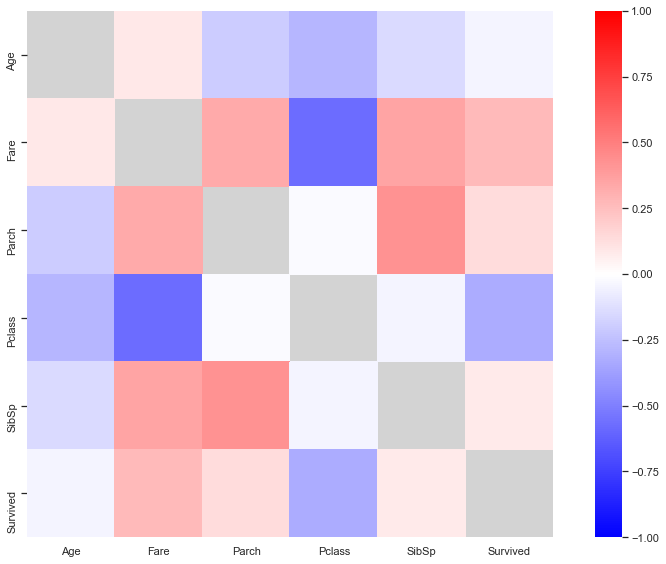

In [13]:
fig, ax = plotPairwiseCorrelation(allCorrelations)

In [14]:
missingVals = showMissing(data)
print(missingVals)

          TotalNA    PropNA
Cabin         687  0.771044
Age           177  0.198653
Embarked        2  0.002245


(<Figure size 864x576 with 4 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

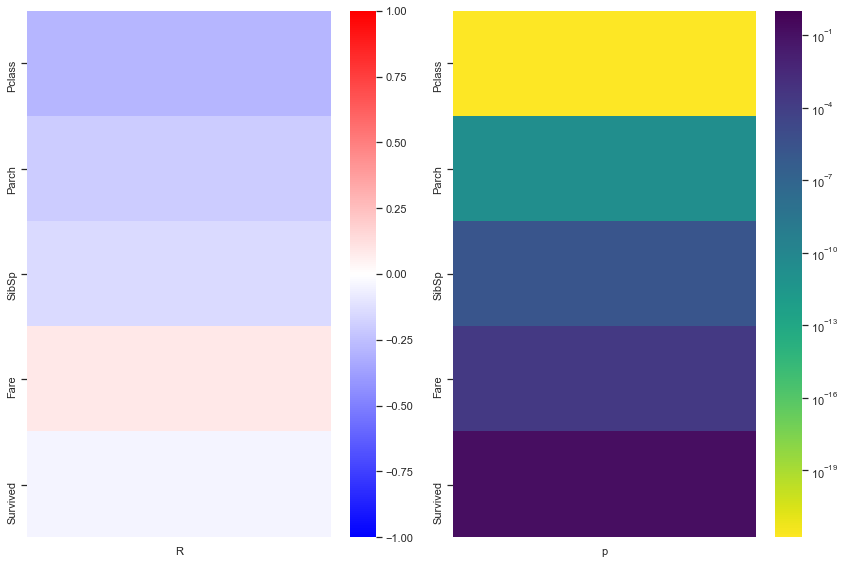

In [15]:
plotTargetCorrelation(allCorrelations, 'Age')

In [16]:
reference = 'Age'
validFeatures = data.select_dtypes(exclude=['float', 'int']).columns
for feature in validFeatures:
    if feature == reference:
        continue
    grouping = [group[reference].dropna().values for _, group in data.groupby(feature)]
    H, p = stats.kruskal(*grouping)
    if not np.isnan(H):
        print(feature, H, p)

Survived 1.970097978146391 0.16043746252207006
Sex 4.951032159109385 0.02607509661801354
Embarked 1.2484133404393043 0.5356862358343728


### Exploring Parch vs Survived
  - Parch feature indicates number of parents/children.

<AxesSubplot:xlabel='Parch', ylabel='Density'>

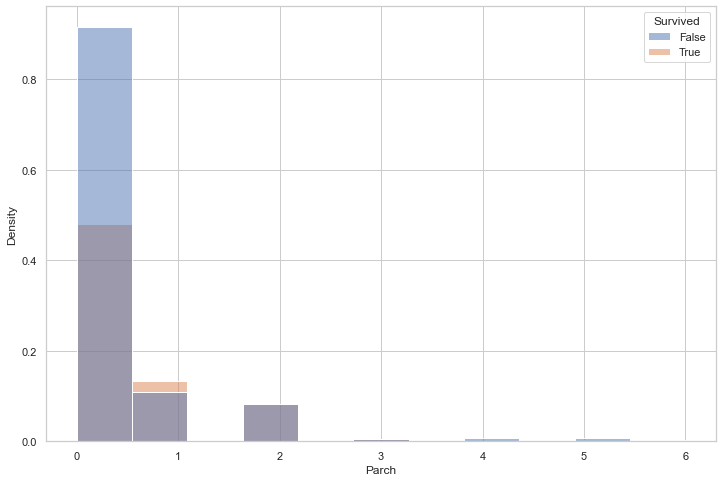

In [17]:
sns.histplot(x='Parch', hue='Survived', stat='density', data=data)

<AxesSubplot:xlabel='FamSize', ylabel='AgeGroup'>

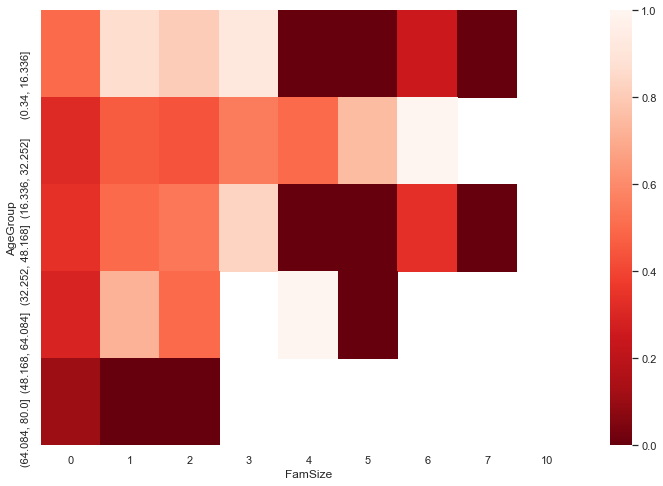

In [18]:
temp = data.copy()
temp['AgeGroup'] = pd.cut(data['Age'], 5)
temp['FamSize'] = temp['Parch'] + temp['SibSp']
temp = temp.groupby(['AgeGroup', 'FamSize'])['Survived'].mean().reset_index()
temp = temp.pivot(index='AgeGroup', columns='FamSize', values='Survived')
sns.heatmap(temp, cmap='Reds_r')

In [19]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())
data['Girl'] = (data['Title'] == 'Miss') & (data['Parch'] > 0)
def estimateAgeGroup(X):
    if (X['Title'] == 'Miss') & (X['Parch'] > 0):
        return 'girl'
    elif (X['Title'] == 'Master'):
        return 'boy'
    elif (X['Sex'] == 'male'):
        return 'man'
    else:
        return 'woman'
data['estAgeGroup'] = data.apply(estimateAgeGroup, axis=1)
data.groupby(['estAgeGroup', 'Pclass'])['Age'].mean()

estAgeGroup  Pclass
boy          1          5.306667
             2          2.258889
             3          5.350833
girl         1         21.000000
             2         10.538462
             3          6.903846
man          1         42.382653
             2         33.588889
             3         28.724891
woman        1         37.768116
             2         32.598361
             3         26.828947
Name: Age, dtype: float64

<AxesSubplot:xlabel='FamSize', ylabel='Survived'>

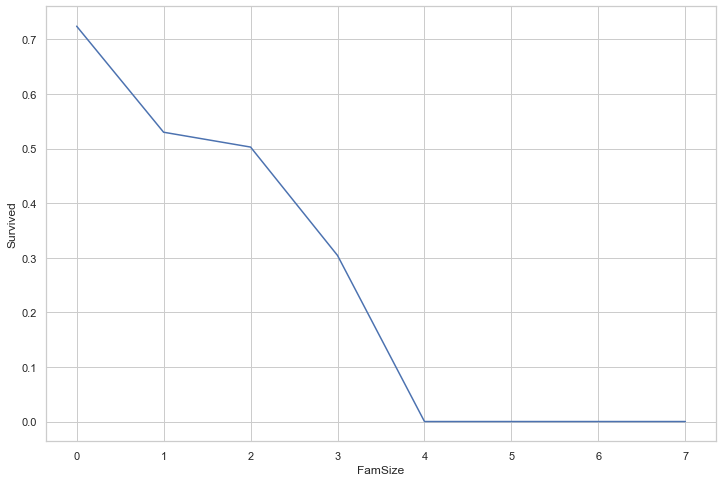

In [20]:
#data['FamSize'] = data['SibSp'].apply(lambda x: x if x > 0 else 2)
data['FamSize'] = abs(4 - (data['SibSp'] + data['Parch'] + 1))
feature = 'FamSize'
temp = data.groupby([feature])['Survived'].mean().reset_index()
sns.lineplot(x=feature, y='Survived', data=temp)

<AxesSubplot:xlabel='Parch', ylabel='SibSp'>

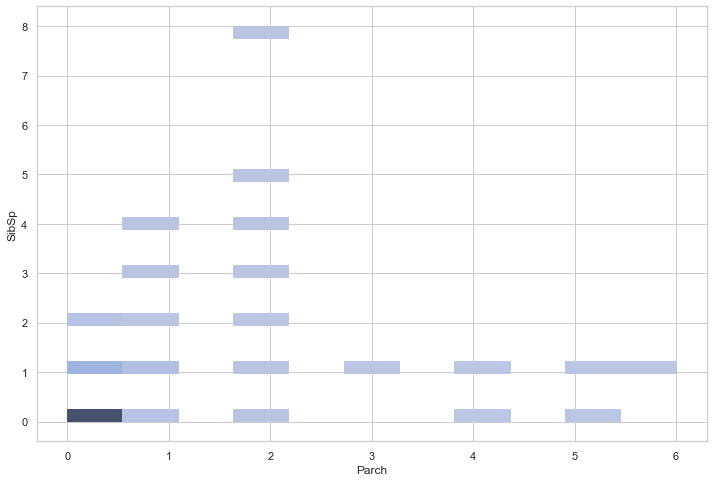

In [21]:
sns.histplot(x='Parch', y='SibSp', data=data[data['Survived']==False])

<AxesSubplot:xlabel='FareAdj', ylabel='Density'>

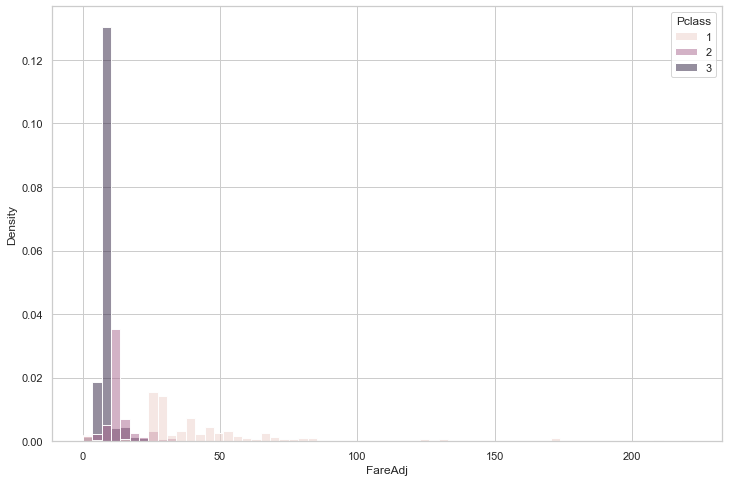

In [22]:
data['x2'] = data['Parch'] + data['SibSp'] + 1 + (data['Age'] / data['Age'].max())
data['TicketFrequency'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FareAdj'] = data['Fare'] / data['TicketFrequency']
sns.histplot(x='FareAdj', hue='Pclass', stat='density', data=data)

In [23]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Girl,estAgeGroup,FamSize,x2,TicketFrequency,FareAdj
PassengerId,,,,,,,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,man,2,2.2750,1,7.2500
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,False,woman,2,2.4750,1,71.2833
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,woman,3,1.3250,1,7.9250
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,False,woman,2,2.4375,2,26.5500
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,man,3,1.4375,1,8.0500


In [24]:
maleSurviveWithFam = (data['Sex'] == 'male') & (data['Title'] != 'Master') & (data['Survived'] == 1) & (data['FamSize'] > 1)
data['Surname'] = data['Name'].apply(lambda x: re.split(',', x)[0])
names = data.loc[maleSurviveWithFam, 'Surname']
data['famSurvive'] = data['Surname'].isin(names)
data[(data['famSurvive'] == True) & (data['Sex'] != 'male') ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Girl,estAgeGroup,FamSize,x2,TicketFrequency,FareAdj,Surname,famSurvive
PassengerId,,,,,,,,,,,,,,,,,,,,
53,True,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,False,woman,2,2.6125,3,25.576400,Harper,True
69,True,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,True,girl,3,7.2125,1,7.925000,Andersson,True
114,False,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,S,Miss,False,woman,2,2.2500,1,9.825000,Jussila,True
120,False,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,Miss,True,girl,3,7.0250,7,4.467857,Andersson,True
231,True,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.0,1,0,36973,83.4750,C83,S,Mrs,False,woman,2,2.4375,2,41.737500,Harris,True
292,True,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C,Mrs,False,woman,2,2.2375,2,45.539600,Bishop,True
403,False,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S,Miss,False,woman,2,2.2625,1,9.825000,Jussila,True
487,True,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S,Mrs,False,woman,2,2.4375,2,45.000000,Hoyt,True
542,False,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,Miss,True,girl,3,7.1125,7,4.467857,Andersson,True


 https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc
        https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer, KBinsDiscretizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn import set_config
from xgboost import XGBClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

In [26]:
set_config(display='diagram')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

In [27]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to optionally impute 
        values by group and return a pandas dataframe. """
    
    def __init__(self, variable, by=[], strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1).values[0]
        else:
            self.strategy = strategy
        self.maps = []

    def fit(self, X, y=None):
        # Store impute for ungrouped data
        self.simpleImpute = X[self.variable].agg(self.strategy)
        # Store maps for all grouping levels
        for i in range(len(self.by), 0, -1):
            subBy = self.by[:i]
            mapper = X.groupby(subBy)[self.variable].agg(self.strategy)
            if i == 1:
                mapper = {(k,): v for k, v in mapper.to_dict().items()}
            self.maps.append((subBy , mapper))
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for (by, mapper) in self.maps:
            fillVals = X[by].apply(tuple, axis=1).map(mapper)
            X[self.variable] = X[self.variable].fillna(fillVals)
            if not X[self.variable].isnull().values.any():
                break
        else:
            # Replace remaining NaN (with ungrouped)
            X[self.variable] = X[self.variable].fillna(self.simpleImpute)
        return X

In [28]:
class GroupImputer2(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to optionally impute 
        values by group and return a pandas Series. """
    
    def __init__(self, variable, by=[], strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1).values[0]
        else:
            self.strategy = strategy
        self.maps = []

    def fit(self, X, y=None):
        # Store impute for ungrouped data
        self.simpleImpute = X[self.variable].agg(self.strategy)
        # Store maps for all grouping levels
        for i in range(len(self.by), 0, -1):
            subBy = self.by[:i]
            mapper = X.groupby(subBy)[self.variable].agg(self.strategy)
            if i == 1:
                mapper = {(k,): v for k, v in mapper.to_dict().items()}
            self.maps.append((subBy , mapper))
        return self

    def transform(self, X, y=None):
        imputed = X[self.variable]
        for (by, mapper) in self.maps:
            fillVals = X[by].apply(tuple, axis=1).map(mapper)
            imputed = imputed.fillna(fillVals)
            if not imputed.isnull().values.any():
                break
        else:
            # Replace remaining NaN (with ungrouped)
            imputed = imputed.fillna(self.simpleImpute)
        return imputed

In [29]:
class FeatureFilter(BaseEstimator, TransformerMixin):
    """ Use for filtering columns by boolean mask """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.columns]

In [30]:
class NoTransformer(BaseEstimator, TransformerMixin):
    """ Dummy transformer """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

In [31]:
def plotFeatureImportance(X, y, prePreprocessor, estimator, vline=None):
    """ Run decision tree ensemble method on a preModel 
        pipline and plot feature importance """
    pipeline = Pipeline(steps=[
        ('prePreprocessor', prePreprocessor),
        ('selector',        estimator)])
    clf = pipeline.fit(X, y)
    columnTransformer = (
        clf.named_steps['prePreprocessor'].named_steps['columnTransform'])
    try:
        selector = clf.named_steps['prePreprocessor'].named_steps['selector']
    except KeyError:
        selector = None
    featureNames = getFeatureNames(columnTransformer, selector)
    features = (pd.DataFrame(
        {'feature': featureNames,
         'importance': clf.named_steps['selector'].feature_importances_})
        .sort_values(by=['importance'], ascending=False))
    
    print(f'Total unfiltered features: {len(featureNames)}')
    fig, ax = plt.subplots()
    sns.barplot(y='feature', x='importance', data=features, ax=ax)
    if vline is not None:
        ax.axvline(vline)
    ax.set_ylabel('')
    ax.set_xlabel('Feature importance')
    fig.tight_layout()

In [352]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """ Custom imputation and feature engineering 
        of Titanic dataset """
    
    def __init__(self):
        self._imputes = {}
        self._models = {}
        

        
    def initData(self, X):
        """ Perform initial feature engineering steps common 
            to fit and transform methods """
        
        X['Title'] = X['Name'].apply(self.getTitle)
        X['Surname'] = X['Name'].apply(self.getSurname)
        X['FamSize'] = X['Parch'] + X['SibSp'] + 1
        # Mask crew fares for imputation
        X['Fare'].replace(0, np.nan) 
        X['ageGroup'] = X.apply(self.estimateAgeGroup, axis=1)
        
        
    def fit(self, X, y=None):
        X = X.copy()
        self.initData(X)
        X['TicketFrequency'] = X.groupby('Ticket')['Ticket'].transform('count')
        # Store surnames of all males (with families) that survived
        maleSurviveWithFam = (
            (X['Sex'] == 'male') & (X['Title'] != 'Master') & 
            (y == 1) & (X['FamSize'] > 1))
        self.maleNames = X.loc[maleSurviveWithFam, 'Surname']
        # Store surnames of all females (with families) that died
        femaleDieWithFam = (
            ((X['Sex'] == 'female') | (X['Title'] == 'Master')) &
            (y == 0) & (X['FamSize'] > 1))
        self.femaleNames = X.loc[femaleDieWithFam, 'Surname']
        self._imputes['Age'] = GroupImputer2(
            'Age', by=['ageGroup', 'Pclass'], strategy='median').fit(X)
        # Compute true ticket frequency and compute mean per fam size
        self._models['TicketFrequency'] = LinearRegression().fit(
            X['FamSize'].to_frame(), X['TicketFrequency'])
        X['FareAdj'] = X['Fare'] / X['TicketFrequency']
        self._imputes['FareAdj'] = GroupImputer2(
            'FareAdj', by=['Pclass'], strategy='median').fit(X)

        return self

    
    def transform(self, X, y=None):
        X = X.copy()
        self.initData(X)
        X['WomenOrChild'] = (X['Sex'] == 'female') | (X['Title'] == 'Master')
        X['Age'] = self._imputes['Age'].transform(X)
        X['famSurvive'] = X['Surname'].isin(self.maleNames)
        X['famDie'] = X['Surname'].isin(self.femaleNames)
        X['TicketFrequency'] = self._models['TicketFrequency'].predict(
            X['FamSize'].to_frame())
        X['FareAdj'] = X['Fare'] / X['TicketFrequency']
        X['FareAdj'] = self._imputes['FareAdj'].transform(X)
        return X
        
        
    def estimateAgeGroup(self, X):
        """ Estimate age/sex group by title for age imputation """
        # Assume unmarried with parents is a girl
        if (X['Title'] == 'Miss') & (X['Parch'] > 0):
            return 'girl'
        elif (X['Title'] == 'Master'):
            return 'boy'
        elif (X['Sex'] == 'male'):
            return 'man'
        else:
            return 'woman'
        
        
    def getTitle(self, x):
        """ Extract title from name """
        return re.split(',|\.', x)[1].strip()
    
    
    def getSurname(self, x):
        """ Extract surname from name """
        return re.split(',', x)[0].strip()

In [353]:
def getFeatureNames(columnTransformer, selector=None):
    """ Extract feature names from column transformer. 
        If transformers are pipelines then encoding step
        should be last step of that pipeline
        Ref: https://github.com/scikit-learn/scikit-learn/issues/12525 
    """
    colNames = np.array([])
    for tupleTransformer in columnTransformer.transformers_[:-1]:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:
            names = tupleTransformer[2]
        # This is for kBinDiscretizers, which have n_bins_ method
        if (isinstance(transformer, KBinsDiscretizer)
                and transformer.encode != 'ordinal'):
            if transformer.encode != 'ordinal':
                nbins = transformer.n_bins_
                newNames = []
                for col, n in zip(names, nBins):
                    newNames = [f'{col}-{i}' for i in range(n)]
                names = newNames
        colNames = np.append(colNames, names)
    if selector is not None:
        colNames = colNames[selector.get_support()]
    return colNames

In [354]:
X = pd.read_csv(train, index_col=index, dtype=dtypes)
y = X.pop(target)

split = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
X_train, X_valid, y_train, y_valid = map(lambda x: x.copy(), split)

# Data pre-processing step

In [355]:
CatTransformer = Pipeline(steps=[
    ('onehot' , OneHotEncoder(handle_unknown='ignore')),
])
FareDiscretizer = Pipeline(steps=[
    ('discrete', KBinsDiscretizer(encode='ordinal', strategy='kmeans'))
])
AgeDiscretizer = Pipeline(steps=[
    ('discrete', KBinsDiscretizer(encode='ordinal', strategy='kmeans'))
])

In [356]:
transformers = ([
    ('Cat',     CatTransformer,  ['Pclass']),
    ('Fare',    FareDiscretizer, ['FareAdj']),
    ('Age',     AgeDiscretizer,  ['Age']),
    ('None',    NoTransformer(), ['famSurvive', 'famDie', 'WomenOrChild', 'FamSize']),
])
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [357]:
# Define a preModel pipeline distinct from modelling step
dataEngineering = Pipeline(steps=[
    ('engineer',        FeatureEngineer()),
    ('columnTransform', preprocessor),
])

## Assessing feature importance

Total unfiltered features: 9


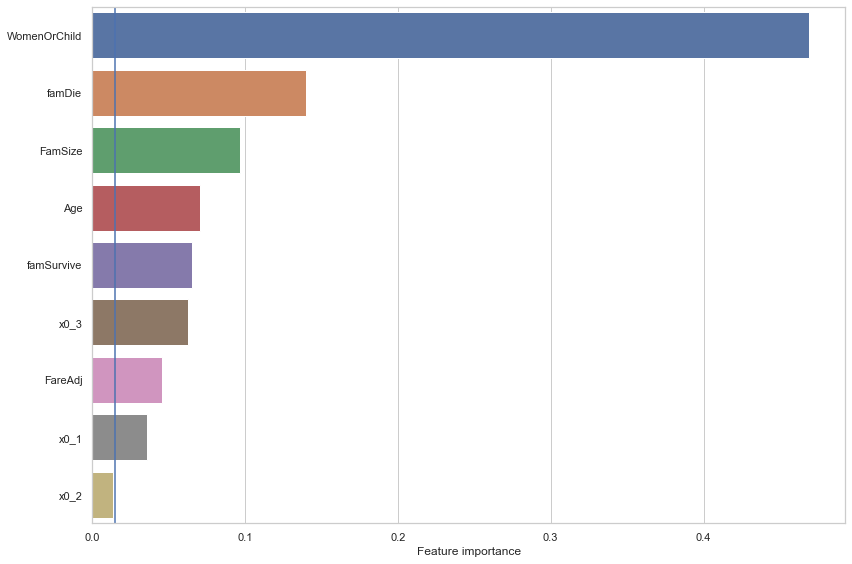

In [358]:
selectEstimator = RandomForestClassifier(random_state=1, n_estimators=500, max_features='sqrt')
plotFeatureImportance(X_train, y_train, dataEngineering, selectEstimator, 0.015)

### Perform feature selection
  - Combine the preProcess pipeline with feature selector.
  - Run feature selection and identify selected features.
  - Selected features and passed to parameter hypertuning pipeline (stage 3).

In [359]:
# Configure the cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
nJobs = 4

In [360]:
featureSelector = Pipeline(steps=[
    ('preProcess',    dataEngineering),
    ('selector',      RFECV(selectEstimator, cv=cv, scoring='accuracy')),
])

In [361]:
# Fit data to pipeline
featureSelector.fit(X_train, y_train)
# Extract columnTransformer and selector to extract feature names
columnTransformer = featureSelector.named_steps['preProcess'].named_steps['columnTransform']
selector = featureSelector.named_steps['selector']
selectedFeatures = selector.get_support()
featureNames = getFeatureNames(columnTransformer, selector)
# Create dataframe of transformed data
transformedDF = pd.DataFrame(
    featureSelector.transform(X_valid), 
    columns=featureNames)

transformedDF.head()

,x0_3,Age,famSurvive,famDie,WomenOrChild,FamSize
0,1,1,False,False,False,1
1,1,1,False,False,False,1
2,1,0,False,True,True,6
3,0,2,False,False,True,2
4,1,1,False,False,True,3


## Estimator hypertuning

In [333]:
fullModel = Pipeline(steps=[
    ('preProcess',    dataEngineering),
    ('featureFilter', FeatureFilter(selectedFeatures)),
    ('model',         RandomForestClassifier(random_state=1)),
])

In [318]:
params =([
    {'preProcess__columnTransform__Fare__discrete__n_bins': Integer(2, 6),
     'preProcess__columnTransform__Age__discrete__n_bins': Integer(2, 6),
     'model__n_estimators':      Integer(100, 1000),
     'model__max_depth':         Integer(3, 20),
     'model__criterion':         Categorical(['gini', 'entropy']),
     'model__max_features':      Integer(1, round(np.sqrt(len(featureNames)))),
},
])

In [319]:
gridSearch = BayesSearchCV(
    fullModel, params, scoring='accuracy', random_state=1,
    cv=cv, refit=True, n_jobs=nJobs, n_iter=100, verbose=1)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=Pipeline(steps=[('preProcess',
                                         Pipeline(steps=[('engineer',
                                                          FeatureEngineer()),
                                                         ('columnTransform',
                                                          ColumnTransformer(transformers=[('Cat',
                                                                                           Pipeline(steps=[('imputer',
                                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                                           ('onehot',
                                                                                                            OneHotEncoder(handle_unknown='ignore'))]),
                                                                                           ['Pclass']),
                                                                                          ('Fare',
                                                                                           Pi...
                              'model__max_features': Integer(low=1, high=3.0, prior='uniform', transform='identity'),
                              'model__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='identity'),
                              'preProcess__columnTransform__Age__discrete__n_bins': Integer(low=2, high=6, prior='uniform', transform='identity'),
                              'preProcess__columnTransform__Fare__discrete__n_bins': Integer(low=2, high=6, prior='uniform', transform='identity')}],
              verbose=1)

In [321]:
score = gridSearch.score(X_valid, y_valid)
print(f'Best score: {score}')

gridSearch.best_params_

Best score: 0.8379888268156425


OrderedDict([('model__criterion', 'gini'),
             ('model__max_depth', 8),
             ('model__max_features', 2),
             ('model__n_estimators', 551),
             ('preProcess__columnTransform__Age__discrete__n_bins', 3),
             ('preProcess__columnTransform__Fare__discrete__n_bins', 4)])

### Generate predictions
 - Refit model with full test dataset

In [322]:
#gridSearch.fit(X, y)
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
predictions = gridSearch.predict(X_test).astype(int)
submission = pd.DataFrame({'PassengerId':X_test.index,'Survived': predictions})
submission.to_csv('submission.csv', index=False)

# Interpretation - assessing feature importance

In [ ]:
import eli5

In [ ]:
preModelTransformer = gridSearch.best_estimator_.named_steps['preModel']
columnTransformer = preModelTransformer.named_steps['columnTransform']
model = gridSearch.best_estimator_.named_steps['model']
featureNames = getFeatureNames(columnTransformer)

### Try out the preModelTransformer

In [ ]:
X.head()

In [ ]:
transformedDf = pd.DataFrame(preModelTransformer.transform(X_valid), columns=featureNames)
transformedDf.head()

In [ ]:
eli5.explain_weights(model, feature_names=featureNames)

In [ ]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
sns.barplot(y='Fare', x='FamilySize', hue='Pclass', data=data)

In [ ]:
data['FareAdj'] = data['Fare'] / data['FamilySize']

In [ ]:
sns.histplot(data=data[data['Pclass']==3], x='FareAdj', hue='Pclass')

In [ ]:
sns.distplot(x='x2', hue='Survived', kind='kde', data=data)

## Hard encoded rules

In [ ]:
class RuleAugmentedEstimator(BaseEstimator, ClassifierMixin):
    """ Augments sklearn estimators with rule-based logic.
        This class is a wrapper class for sklearn estimators with the additional
    possibility of adding rule-based logic to the underlying estimator.
    The provided rules are hard-coded and take precedence over the underlying
    estimator's predictions.
    """

    def __init__(self, base_model: BaseEstimator, **baseParams):  
        self.base_model = base_model
        self.base_model.set_params(**baseParams)

   
    def _get_base_model_data(self, X, y):
        """Filters the trainig data for data points not affected by the rules."""
        
        train_x = X
        male23 = (train_x['Sex'] == 'male') & (train_x['Pclass'] != 1)
        fem1 = (train_x['Sex'] == 'female') & (train_x['Pclass'] == 2)
        mask = [any(tup) for tup in zip(male23, fem1)]
        train_x = train_x.loc[mask]
        train_y = y.loc[mask]
        
        train_x = train_x.reset_index(drop=True)
        train_y = train_y.reset_index(drop=True)
        
        return train_x, train_y   

    
    def fit(self, X, y, **kwargs):
        train_x, train_y = self._get_base_model_data(X, y)
        self.base_model.fit(train_x, train_y, **kwargs)
    
    
    def predict(self, X: pd.DataFrame) -> np.array:
        """Gets predictions for the provided feature data.
        
        The predicitons are evaluated using the provided rules wherever possible
        otherwise the underlying estimator is used.
        
        Args:
            X: The feature data to evaluate predictions for.
        
        Returns:
            np.array: Evaluated predictions.
        """
        
        p_X = X.copy()
        p_X['prediction'] = np.nan
        p_X.loc[(p_X['Sex'] == 'male') & (p_X['Pclass'] != 1), 'prediction'] = False
        p_X.loc[(p_X['Sex'] == 'female') & (p_X['Pclass'] == 1), 'prediction'] = True
        
        if len(p_X.loc[p_X['prediction'].isna()].index != 0):
            base_X = p_X.loc[p_X['prediction'].isna()].copy()
            base_X.drop('prediction', axis=1, inplace=True)
            p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)
        return list(p_X['prediction'])
    
    
    def get_params(self, deep: bool = True):
        return self.base_model.get_params(deep=deep)
    
